## Model Evaluation & Model Selection 
1. Why model Evaluation 
2. Selecting Model Evaluation Metric carefully, DummyClassifiers / DummyRegressors
3. Evaluation Metrics 
  - Confusion Matrix , use of DummyClassifier 
  - Metrics derived from confusion matrix , examples of scenarios where to use  
4. Examples of using them in sklearn, comparing with Dummy eval metrics  
5. Parameter to Model Evaluation 
  - Decision Threshold 
  - How to evaluate models with eval metrics, with unknown decision threshold 
    - ROC, Precision recall curves, AUC  
6. Multi-class Model Evaluation  
  - Confustion Matrix Visualization 
  - Precision Recall metrics : macro, micro, weighted approaches  
7. Regression Evaluation   
8. Other model evaluation measures
  - Covered in SL 101
  - Lift  
  - Learning curve 
  - Parameter sensitivity analysis. 
## Model Selection 
- Using Evaluation metrics for model selection
- Using train /test split for model building, selection and evaluation 


#### 1. Why model Evaluation  
- **Models are trained with objective functions that are surrogate or are close to the objectives of the application in a business setting, Hence, identifying the right evaluation metrics to evaluate model performance as per application/business setting is important** 
  - Example : Health care tumor detection
    - Decision tree classifer trained to reduce Gini Impurity in a greedy manner 
    - Logistic Regression classifier trainer to reduce log loss /log likelihood
  - But, the business application evaluation would be like - 
    - Identify tumor cases with more accuracy then a human doctor can. 
    - Reduce False positives. 
    - The evaluation metrics of interest then becomes - Sensitivity or TPR
  - Example : Search engine, say predicting search topic, to showcase relevant query result 
    - Classification models on log loss, or other loss functions for example 
    - Business evaluation : 
      - Time spent by users on search results
    - **Often, there are multiple evaluation metrics that are evaliated as part of a scorecard, like in a commercial   
      search engine performance tracking**
- Helps in the feature representation -> Training -> Evaluation ->Refinement cycle
  - Refinement can be in learning where model is not performing  
  - Utilizing different features, sampling strategy or classifier 

#### 2. Selecting Model Evaluation Metric carefully, using DummyClassifiers  
- Imbalanced Classes
  - Real world processes genrate imbalanced data 
    - Users clicking a relevant ad are far less than not clicking any. Modeling a click/not click decision will have 
    imbalanced data 
    - Product recommendations / Cross sell. 
    - Fraud
  - Accuracy as a metric is not a good evaluation metric, because a Dummy classifier, not making use of any feature, can predict everything as the major class, and get high accuracy
  - **sklearn provides a DummyClassifier class to measure classifier performance against dummy scenarios**
  Strategies -
    - most_frequent : 
    - uniform : each label has an equal chance of prediction
    - stratified : probability of each class prediction as per class frequencies in training data 
    - constant
  - For DummyRegression, strategies : 
    - mean, median, quantile, constant 
  - What they help point out 
    - Imbalanced set, and classifier objective function is biased towards majority labels 
    - Non informative features 
    - Poor choice of hyperparameters 

#### Example of digit classiciation  and use of DummyClassifiers
- accuracy with imblanced set is same as that of Dummy classifier predicting most frequent class

In [173]:
import numpy as np
import pandas as pd 
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix,\
precision_recall_curve,roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('bmh')
%matplotlib inline
# For displaying high resolution images inline
%config InlineBackend.figure_format = 'retina'

In [174]:
data = load_digits()
X = data.data
Y = data.target
print(np.bincount(Y))
Y_ = Y.copy()
Y_[Y_ != 1] = 0
print(np.bincount(Y_))

[178 182 177 183 181 182 181 179 174 180]
[1615  182]


In [175]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y_, test_size = 0.2, shuffle = True, 
                                                    stratify = Y,random_state = 22)
clf_rbf = SVC(kernel= 'rbf', C = 0.1)
clf_rbf.fit(X_train,Y_train)
print('Classifier score of SVC with RBF:', clf_rbf.score(X_test, Y_test))

clf_lin = SVC(kernel= 'linear', C = 0.1)
clf_lin.fit(X_train,Y_train)
print('Classifier score of SVC with linear kernel:', clf_lin.score(X_test, Y_test))

clf_dummy_1 = DummyClassifier(strategy= 'most_frequent')
clf_dummy_1.fit(X_train,Y_train)
clf_dummy_2 = DummyClassifier(strategy= 'stratified')
clf_dummy_2.fit(X_train,Y_train)
clf_dummy_3 = DummyClassifier(strategy= 'uniform')
clf_dummy_3.fit(X_train,Y_train)
clf_dummy_4 = DummyClassifier(strategy= 'constant', constant = 1)
clf_dummy_4.fit(X_train,Y_train)
print('Dummy score with strategy as most frequent class :',clf_dummy_1.score(X_test, Y_test))
print('Dummy score with strategy as stratified class :',clf_dummy_2.score(X_test, Y_test))
print('Dummy score with strategy as uniform  :',clf_dummy_3.score(X_test, Y_test))
print('Dummy score with strategy as constant class 1 :',clf_dummy_4.score(X_test, Y_test))


/Users/sumad/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Classifier score of SVC with RBF: 0.897222222222
Classifier score of SVC with linear kernel: 0.980555555556
Dummy score with strategy as most frequent class : 0.897222222222
Dummy score with strategy as stratified class : 0.805555555556
Dummy score with strategy as uniform  : 0.55
Dummy score with strategy as constant class 1 : 0.102777777778


#### 3. Evaluation Metrics

#### 3.1 Confusion Matrix
- Confusion matrix gives a lot more information than overall accuracy 
- Created for binary and multi-class classiciation
- **Assumes a decision threshold, for probability models like LR -0.5, for kernelized SVMs, it is sign of the distance**
- In sklearn format is :  

|--|Pred_0|Pred_1|
|:-|:-|:-|
|Act_0|TN|FP|
|Act_1|FN|TP|

In [176]:
print('Conf matrix for SVC rbf')
print(confusion_matrix(Y_test, clf_rbf.predict(X_test)))

print('Conf matrix for SVC linear')
print(confusion_matrix(Y_test, clf_lin.predict(X_test)))

print('Conf matrix for dummy most_fre')
print(confusion_matrix(Y_test, clf_dummy_1.predict(X_test)))

print('Conf matrix for dummy stratified')
print(confusion_matrix(Y_test, clf_dummy_2.predict(X_test)))

print('Conf matrix for dummy uniform')
print(confusion_matrix(Y_test, clf_dummy_3.predict(X_test)))

Conf matrix for SVC rbf
[[323   0]
 [ 37   0]]
Conf matrix for SVC linear
[[318   5]
 [  2  35]]
Conf matrix for dummy most_fre
[[323   0]
 [ 37   0]]
Conf matrix for dummy stratified
[[282  41]
 [ 33   4]]
Conf matrix for dummy uniform
[[181 142]
 [ 19  18]]


#### 3.2 Metrics derived from confusion matrix , examples of scenarios where to use the metrics 
- Overall accuracy is mostly not how a model is evaluated for business applications 
- There are two truths in confusion matrix, one for positive class (TP), other for negative (TN), ideally we want both 
  false predictions to be reduced in favor of truths (zero FP and FN)
  - Opposing relationship (TP<->FN) and (TN<->FP), shown below
  - **If you try to improve one of these, i.e TP or TN,(not both) coz in most real data, a clean separation (100% accuracy) through a model is usually impossible to obtain, you end up screwing the other - this is what picture below shows, moving 3 FNs to TPs, results in movement of 2 TNs to FPs**
  - **We can derive metrics from confusion matrix, that favor one truth over the other based on real world requirement. Multiple metrics can be derived from confusion matrix, if you think about it.**
  - Decision boundary of classifier is changed (either using new classifier or adjusting features, hyper prams etc) to optimize the chosen eval. metric, representation below, but in doing so, other metrics most likely degrade; and a tradeoff becomes evident 
  - Example : In tumor classification, the applicability requirement could be to reduce FNs/i.e increase TPs.
  **But, it usually turns out, when you adjust the decision boundary to do that, you also end up degrading False Positives/True Negatives, so the question becomes - are we ok in suffering on FPs and can put add'l resources to manually scan out FP cases; and in that case model performance can be evaluated using precision as a metric, OR do we want to strike a balance, and utilize f1-score or a weighted form of f1-score.**
  - Model evaluations usually requires creating these metrics, and making users aware of fallouts and controlling mechanims needed to deal with them 
  - **More metrics possible to define like Profit, Cost etc**

<img src = "images/IMG_2419.jpg" style = "width:600px; height:400px;">  

- Key Metrics from confusion matrix 
  - TPR / Recall / Prob. of detection / Sensitivity = TP/(TP+ FN)
  - Precision = TP/(TP+FP)  
  - TNR = TN/(TN + FP) 
  - FPR / Specificity = 1-TNR = FP/(FP+TN) i.e what instances of all negatives, are incorrectly identfied as positive
- Often seen tradeoffs in applications 
  - Precision/ Recall 
  - TPR / TNR 
- F-Score 
  - $\frac{(1+ \beta^2) * Precision * Recall}{\beta^2 * Precision + Recall}$ 
- F1-Score: Generalization of F score when Beta = 1, harmonic mean of precision and recall  
  - $\frac{2 * Precision * Recall}{ Precision + Recall}$  
  - When precision is given more importance than recall, Beta = 0.5 i.e FP is more important than FN 
  - When recall is of more importance, Beta = 2 
  - Both equally important, Beta = 1
  - **Beta allows adjustment between importance of precision and recall**

#### Examples of business scenarios and apt evaluation metric 
1. Search engine ranking requirements / Many customer facing models 
  - Whatever we show to the user, should be accurate; users get turned off from bad results very quickly
  - It is ok to show no results than bad results
  - For a model's evaluation : TP(high), FP(low) ; so precision is a good metric to evaluate  
  - **What can you do if FNs increase? Design a process to control?**
2. Disease detection / Fraud detection
  - We should get detection right, atleast to the level of a human doctor  (high TP)
  - We should fail less to catch the disease (reduce FN)
  - Recall is a good metric to evaluate
  - **What do you do if FPs increase ? Often paired with human to handle fallout of higher FPs**

#### 4. Examples of using them in sklearn, comparing with Dummy eval metrics 
- We can evaluate multiple models after scoring them on test set, like on precision, recall, f1; and also compare
them with a dummy classifier 

In [177]:
print('Dummy model Eval metrics with strategy as uniform:\n',classification_report(Y_test, 
                                                                                   clf_dummy_3.predict(X_test),
                                                                                  target_names = ['0', '1']))
print('Eval metrics for clf_rbf :\n',classification_report(Y_test, clf_rbf.predict(X_test),
                                                                                  target_names = ['0', '1']))
print('Eval metrics for clf_lin :\n',classification_report(Y_test, clf_lin.predict(X_test),
                                                                                  target_names = ['0', '1']))      

Dummy model Eval metrics with strategy as uniform:
               precision    recall  f1-score   support

           0       0.92      0.50      0.65       323
           1       0.13      0.65      0.21        37

   micro avg       0.51      0.51      0.51       360
   macro avg       0.53      0.57      0.43       360
weighted avg       0.84      0.51      0.60       360

Eval metrics for clf_rbf :
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       323
           1       0.00      0.00      0.00        37

   micro avg       0.90      0.90      0.90       360
   macro avg       0.45      0.50      0.47       360
weighted avg       0.81      0.90      0.85       360

Eval metrics for clf_lin :
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       323
           1       0.88      0.95      0.91        37

   micro avg       0.98      0.98      0.98       360
   macro avg       0

/Users/sumad/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 5. Parameter to Model Evaluation  

#### 5.1 Decision  Threshold
Classifier model can be probability based (LR,Decision trees etc) or Distance based (kernelized SVMs). 
The conversion of probability or distance estimate uses a probability (0.5 default) and distance (0) threshold.
The threshold acts as a parameter in model evaluation using evaluation metrics

<img src = "images/IMG_8270.jpg" style = "width:600px; height:400px;">  

#### Decision function and predict_proba
- In logistic regression, decision_function gives distance of a point from the learned linear function 
$\beta_0 +...+ \beta_n* x_n $, for SVM gives distance of point from the dividing hyperplanne 
- predict_proba function for logistic regression , gives the predicted probability of major and minor class in an array, may not give valid output for SVM, unless prob. is separately estimated 

In [178]:
clf_lr = LogisticRegression(C = 0.1)
clf_lr.fit(X_train,Y_train)

/Users/sumad/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [179]:
print('LR decision function output :',clf_lr.decision_function(X_test)[0:10])
print('LR predict_proba function output for class 1:',clf_lr.predict_proba(X_test)[0:10,1])
print('Actual class labels:',Y_test[0:10])

LR decision function output : [ -7.9318428  -16.80171034 -15.39067045   3.5170681    5.36480255
 -10.45034559 -13.63065526 -21.18942827  -1.9421677  -10.13056914]
LR predict_proba function output for class 1: [  3.58995085e-04   5.04789008e-08   2.06974414e-07   9.71169526e-01
   9.95343401e-01   2.89374333e-05   1.20304289e-06   6.27405364e-10
   1.25409906e-01   3.98412011e-05]
Actual class labels: [0 0 0 1 1 0 0 0 0 0]


In [180]:
print('SVC decision function output :',clf_lin.decision_function(X_test)[0:10])
print('Actual class labels:',Y_test[0:10])

SVC decision function output : [ -6.49254779 -14.31533981 -16.5898249    4.61986709   4.24661476
  -8.93718792 -11.23555666 -18.01782904   0.57254438  -6.5566252 ]
Actual class labels: [0 0 0 1 1 0 0 0 0 0]


#### 5.2 How to evaluate models with eval metrics and decision/probability threshold 
- Varying thresholds can give varying evaluation metrics 
- **Higher values generally make prediction of positive class more conservative, hence they favor precision, opposite is true for recall**
- Right values of thresholds are not known, so evaluation metrics are viewed with varying decision thresholds using two major means 
  - Precision Recall Curve 
  - ROC Curve

##### 5.2.1 Precision Recall Curve

In [181]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(Y_test, clf_lr.predict_proba(X_test)[:,1])
print(thresholds_svc[0:5])

[ 0.04464246  0.04926577  0.05279282  0.0564979   0.07318969]


#### Key points 
- The best point on this curve is right top, where both precision and recall are 1 
- More steep the cureve, better it is 
- **Ideally on this curve we should mark the threshold values or plot a different curve like below**

(0, 1.1)

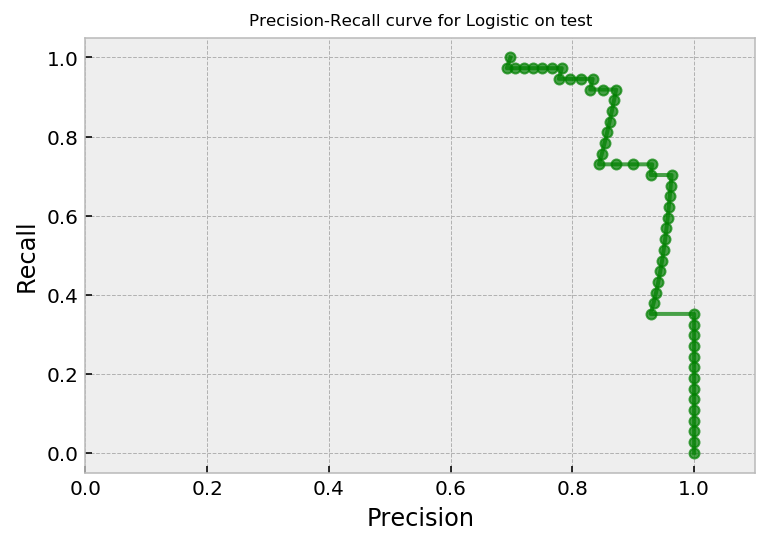

In [182]:
plt.figure()
plt.plot(precision_lr, recall_lr, 'go-', alpha = 0.7, markersize = 5)
#plt.plot(thresholds_svc, precision_svc, 'go-', alpha = 0.7)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve for Logistic on test', fontsize = 'small')
plt.xlim([0,1.1])

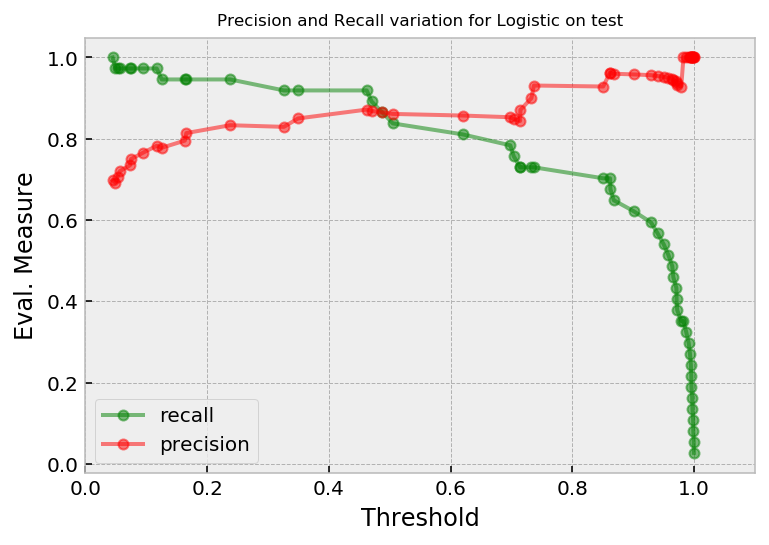

In [183]:
# ladt points are added for the heck of taking precision and recall values to 1
plt.figure()
plt.plot(thresholds_lr, recall_lr[0:-1], 'go-', alpha = 0.5, markersize = 5, label = 'recall')
plt.plot(thresholds_lr, precision_lr[0:-1], 'ro-', alpha = 0.5, markersize = 5, label = 'precision')
plt.xlabel('Threshold')
plt.ylabel('Eval. Measure')
plt.title('Precision and Recall variation for Logistic on test', fontsize = 'small')
plt.xlim([0,1.1])
plt.legend()

##### 5.2.2 ROC Curve
- Depicts variation of TPR and FPR with threshold 
- **Ideal point is 1 TPR and 0 FPR, left topmost point**
- **Aread under curve is an often used evaluation metric**
   - As threshold is low, TPR/Recall is expected to be high, and FPR, Precision low
   - But, as threshold is increased, expectation is TPR will decrease and FPR will also decrease (**check the points labeled on curve below** )
   - If a classifier is able to maintain high TPR and low FPR, with increase in threshold, it shows the evaluatio metric is not very sensitive to decision boundary changes due to change in threshold, and has a clean separation between classes.  
- Also shows how sensitive classifier is to choice of threhold /  how good separtion is between classes 

##### AUC
- This idea is captured by AUC, a single metric to capture ROC curve
   - AUC = 0.5 or less (bad)
   - as it increases and gets close to 1, better
- AUC is also interpreted as probability that a randomly chosen positive class case has a higher probability than a 
randomly chose negative class case. So, this idea aligns with how much separation there is between probabilities of 
positive and negative class probabilities  

**Disadvantages**
- Being a single metric, it looses information, esp. on trandeoff b/w TPR and FPR, in thresholds that would be 
  practical ( arounf 0.5). 
- This becomes important when ROC curves overlap, you may be interested in AUC in a specific range of thresholds   

In [184]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, clf_lr.predict_proba(X_test)[:,1])

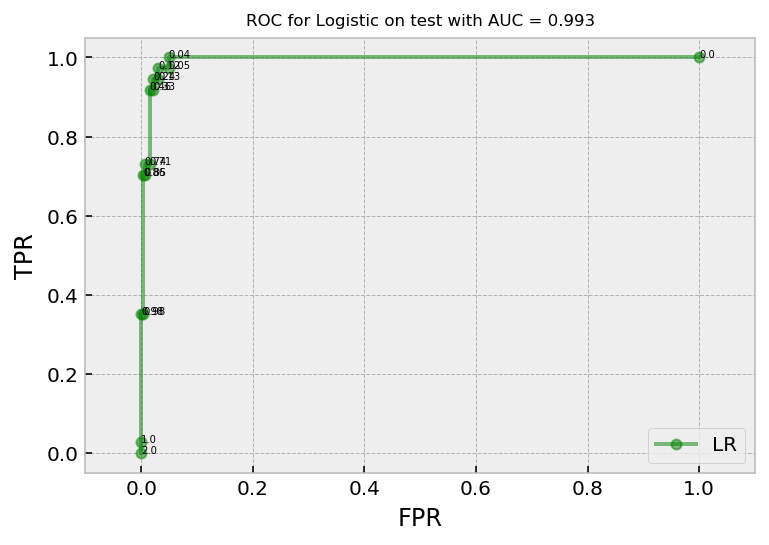

In [185]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, 'go-', alpha = 0.5, markersize = 5, label = 'LR')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for Logistic on test with AUC = {0:.3f}'.format(auc(fpr_lr, tpr_lr)),
          fontsize = 'small')
plt.xlim([-0.1,1.1])
plt.legend()
for x,y,s in zip(fpr_lr, tpr_lr,thresholds_lr):
    plt.text(x,y,str(np.round(s,2)), fontsize = 5)

In [118]:
fpr_lin, tpr_lin, thresholds_lin = roc_curve(Y_test, clf_lin.decision_function(X_test))

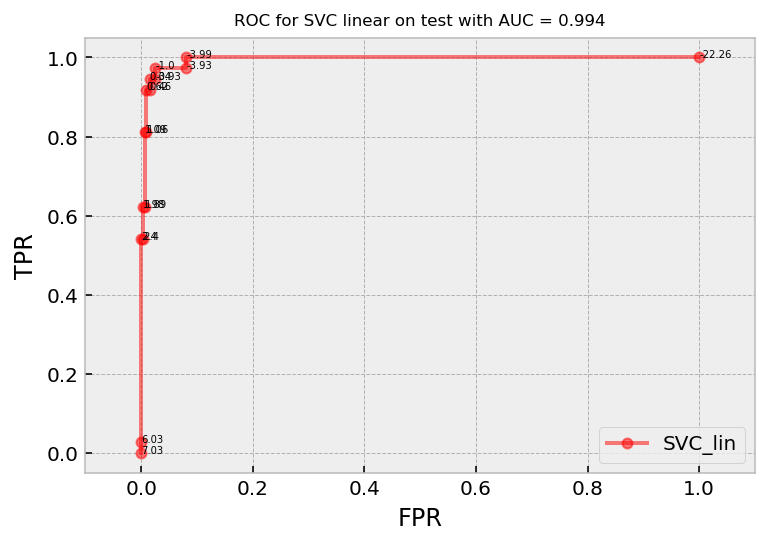

In [186]:
plt.figure()
plt.plot(fpr_lin, tpr_lin, 'ro-', alpha = 0.5, markersize = 5, label = 'SVC_lin')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for SVC linear on test with AUC = {0:.3f}'.format(auc(fpr_lin, tpr_lin)),
          fontsize = 'small')
plt.xlim([-0.1,1.1])
plt.legend()

for x,y,s in zip(fpr_lin, tpr_lin, thresholds_lin):
    plt.text(x,y,str(np.round(s,2)), fontsize = 5)

#### 6. Multi-class Model Evaluation  
- Evaluation metrics are an extension of binary case, except that we look at eval metrics for class 1 in binary case 
- There is a difference here, in that, we can  arrive at a single eval metric considering multiple classes now
- Methods:
  - average individual metrics : Give each class equal weight , called **Macro averaging**
  - Give each scored sample equal weight / compute metric ab initi, equivalent to giving classes weight acc. to their 
  frequency; called **micro averaging**

#### 6.1 Confustion matrix visualization
- made easy using heatmap, can spot mis-classifications easily

In [187]:
X = data.data
Y = data.target
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True, 
                                                    stratify = Y,random_state = 22)
clf_rbf = SVC(kernel= 'rbf', C = 1, gamma = 0.01, decision_function_shape = 'ovr')
clf_rbf.fit(X_train,Y_train)
print('Classifier score of SVC with RBF:', clf_rbf.score(X_test, Y_test))

clf_lin = SVC(kernel= 'linear', C = 0.1, decision_function_shape = 'ovr')
clf_lin.fit(X_train,Y_train)
print('Classifier score of SVC with linear kernel:', clf_lin.score(X_test, Y_test))
cmatrix_lin = confusion_matrix(Y_test, clf_lin.predict(X_test))
cmatrix_rbf = confusion_matrix(Y_test, clf_rbf.predict(X_test))

Classifier score of SVC with RBF: 0.841666666667
Classifier score of SVC with linear kernel: 0.977777777778


Text(0.5, 1.0, 'Confusion matrix for digit classiciation \non test test using SVC rbf clf')

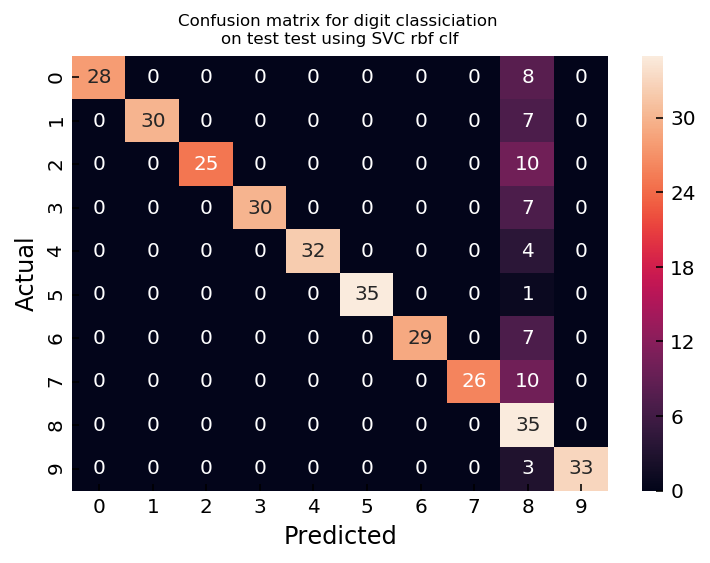

In [188]:
plt.figure()
sns.heatmap(pd.DataFrame(cmatrix_rbf, index = range(0,10), columns = range(0,10)), 
            annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for digit classiciation \non test test using SVC rbf clf', fontsize = 'small')

Text(0.5, 1.0, 'Confusion matrix for digit classiciation \non test test using SVC linear clf')

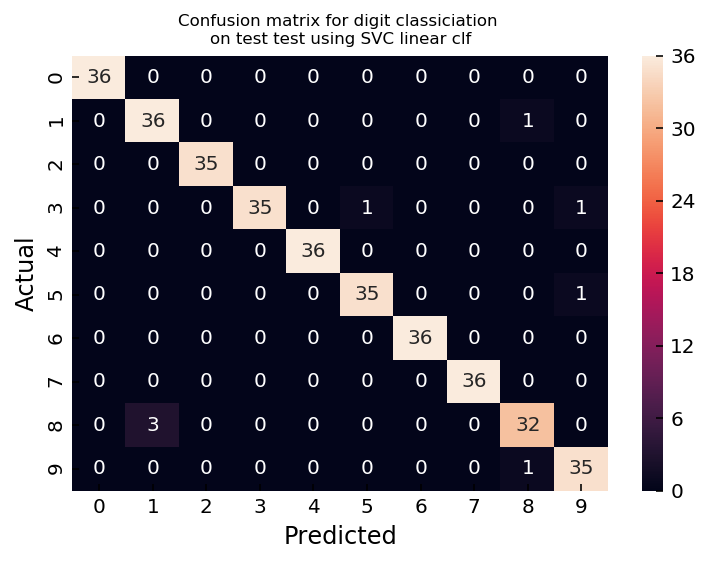

In [189]:
plt.figure()
sns.heatmap(pd.DataFrame(cmatrix_lin, index = range(0,10), columns = range(0,10)), 
            annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for digit classiciation \non test test using SVC linear clf', fontsize = 'small')

#### 6.2 Weighting scheme to compute metrics  
- micro averaging  
- macro averaging  
- weighted 
- sample

In [190]:
print('CF report of rbf clf \n',classification_report(Y_test, clf_rbf.predict(X_test)))

CF report of rbf clf 
               precision    recall  f1-score   support

           0       1.00      0.78      0.88        36
           1       1.00      0.81      0.90        37
           2       1.00      0.71      0.83        35
           3       1.00      0.81      0.90        37
           4       1.00      0.89      0.94        36
           5       1.00      0.97      0.99        36
           6       1.00      0.81      0.89        36
           7       1.00      0.72      0.84        36
           8       0.38      1.00      0.55        35
           9       1.00      0.92      0.96        36

   micro avg       0.84      0.84      0.84       360
   macro avg       0.94      0.84      0.87       360
weighted avg       0.94      0.84      0.87       360



- Macro Average is average of metrics computed on individual class
  - **So, each class's score gets equal weightage, even if some classes may be dominant**
  - **We may want to use this when we want classifier to be equally efficient in precision/recall of all classes**
- Micro average 
  - Look at overall TP , TN, FP, FN numbers 
    - micro precision : (28 + 30 + 25 + 30 + 32 +35 + 29 + 26 +35 + 33)/360 = 0.84 
    - micro recall: same, becase TP + FN will cover all cases. 
- weighted 
  - gives weight to metric of each class, proportional to their support (i.e true cases)  
- samples 
  - for multi-label problems (TBD)
    - Eg: a document can have multiple labels , soft clustering

#### 7. Regression Evaluation metrics 
- R_sq, MAE, MSE, RMSE, Median AE 
- Comparabe with DummayRegression strategies
  - mean, median, a quantile and a constant
- In classicial regression, model evaluation test are done to validate regression assumptions
- Other validation metrics like Lift can be defined for regression as well, esp. in GLMs where samples are weighted
  by quantities like exposure , in insurance applications. 
  - Actual vs Error across discretized variables to see monotonic increase with increase in variable  

#### 8. Other model evaluation measures
- Covered in SL 101 like Lift, K_S statistic. 
- Learning Curve 
  - Helps to determine if model performance improves, as more labeled data is added  
  - Can serve as cost/benefit analysis before going for labeled data  
- Parameter sensitivity analysis 
  - How model performance varies with slight changes in important model parameters that have practical performance impacts as parameters change. 
  -  Tree depth in decison trees, number of trees in random forest. 
- Many other, some like ensuring models do not bias against any segment of population.   

## Model Selection

#### 9. Model selection using evaluation metric 
- **Classifier and Regressors parameterized by different params are candidate models**
  - parameter selection/model selection in this way is done using grid search CV approach. When doing parameter tuning, it is preferred to select parameters/models using evaluation criteria that will be used for model application 
- **Model selection from candidates that are different classifiers/regressors**
  - **Based on performance estimation** : Each model's performance on **desired evaluation metric** can be evalauated using cross validation strategy**which is primarily meant to get an estimate of performance on unseen data**. Each model's performance estimate can be generated using CV, but if the parametrs were to be tuned for each model, **nested cv** is an unbiased approach of getting a performance evaluation of model selection method, discussed [here](http://localhost:8888/notebooks/Documents/DS/Python/UM%20Spcialization/Machine_Learning/Week%202/5_Tuning_Model_Hyperparameters.ipynb)
  - Default scoring in sklearn's classifiers in ***accuracy**, can be changed using scoring argument, which takes a
  string with name of scoring metric. We have seen before how to contruct and use them in above link   
  - **Complexity and Performance tradeoff**
  - **Based on other application needs** 
    - Speed of learning of model. 
    - Memory footprint to store and score new data using the model
- **Evaluation metric used to evaluate and select models can results in different decison boundaries, so need to be careful with selection of eval metric, well worth examining decision boundaries**   
- **Subtle overfitting due to model performance evaluation on data being used for model selection**
  - So, practically, splitting mechanis amd model building is done as 
    - train data : model building and parameter tuning using cv strategy and using model performance on evaluation. metics for tuning   
    - test set : model evaluation, performance estimate generation, can use CV to generate estimates of performance

#### List of eval metrics available

In [192]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

##### Evaluation metric used to evaluate and select models can results in different decison boundaries, so evaluation metric must be chosen carefully, and it might be well worth the repercussions of this choice

In [205]:
def plot_db(clf, X, Y, i, metric):
    ax = plt.subplot(2,2, i+1)
    c_points = ListedColormap(['yellow', 'blue' ])
    c_bound = ListedColormap(['lightyellow', 'skyblue'])
    plt.scatter(X[:,0], X[:,1], c = Y, 
                cmap = c_points,alpha = 0.7, edgecolor = 'black',s= 10)
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])
    #print(x.shape)
    pred = clf.predict(x).reshape(xx.shape)
    #print(pred.shape)
    plt.pcolormesh(xx,yy,pred,cmap = c_bound)
    plt.scatter(X[:,0], X[:,1], c = Y, 
                cmap = c_points,alpha = 0.7, edgecolor = 'black',s= 10)
    plt.title('{0} oriented SVC'.format(metric), fontsize = 'small')

Grid best parameter (max. precision): {'class_weight': {0: 1, 1: 2}}
Grid best score (precision): 0.5338766183339803
Grid best parameter (max. recall): {'class_weight': {0: 1, 1: 50}}
Grid best score (recall): 0.9213861491144341
Grid best parameter (max. f1): {'class_weight': {0: 1, 1: 3}}
Grid best score (f1): 0.5336741346794647
Grid best parameter (max. roc_auc): {'class_weight': {0: 1, 1: 4}}
Grid best score (roc_auc): 0.8910194071400065


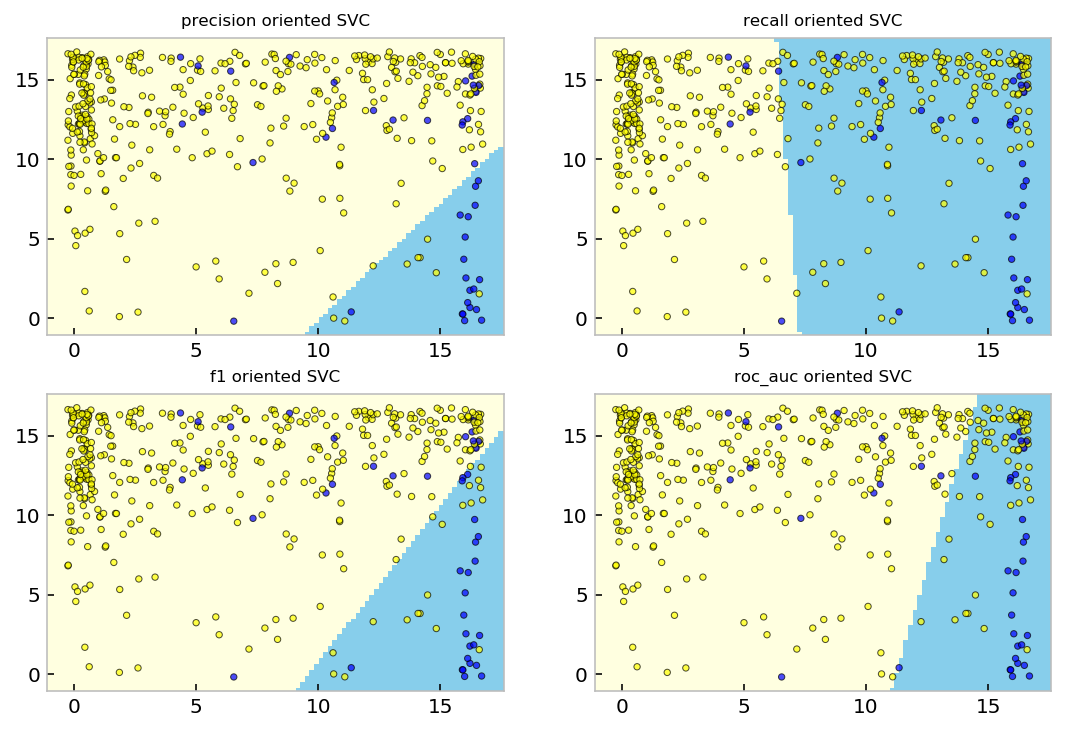

In [206]:
dataset = load_digits()
X, y = dataset.data, dataset.target == 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a two-feature input vector matching the example plot above
# We jitter the points (add a small amount of random noise) in case there are areas
# in feature space where many instances have the same features.
jitter_delta = 0.25
X_twovar_train = X_train[:,[20,59]]+ np.random.rand(X_train.shape[0], 2) - jitter_delta
X_twovar_test  = X_test[:,[20,59]] + np.random.rand(X_test.shape[0], 2) - jitter_delta

clf = SVC(kernel = 'linear').fit(X_twovar_train, y_train)
grid_values = {'class_weight':['balanced', {0:1,1:2},{0:1,1:3},{0:1,1:4},{0:1,1:5},{0:1,1:10},
                               {0:1,1:20},{0:1,1:50}]}
plt.figure(figsize=(9,6))
for i, eval_metric in enumerate(('precision','recall', 'f1','roc_auc')):
    grid_clf_custom = GridSearchCV(clf, param_grid=grid_values, scoring=eval_metric, cv = 5)
    grid_clf_custom.fit(X_twovar_train, y_train)
    print('Grid best parameter (max. {0}): {1}'
          .format(eval_metric, grid_clf_custom.best_params_))
    print('Grid best score ({0}): {1}'
          .format(eval_metric, grid_clf_custom.best_score_))
    plot_db(grid_clf_custom, X_twovar_test, y_test, i,eval_metric )
    